In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

In [81]:
#Data from vizier without treatment
raw_data = pd.read_csv(r"C:\Users\clauw\Documents\Programming\VIS_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])
curve_standard = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\Characterization\Third signature\standard_curve.xlsx")

curve_standard

,Vel fit,Vel values
0,0.982725,-658.000000
1,0.977680,-652.421488
2,0.972416,-646.842975
3,0.966937,-641.264463
4,0.961250,-635.685950
...,...,...
117,0.294406,-5.314050
118,0.299970,0.264463
119,0.305939,5.842975
120,0.312321,11.421488


In [3]:
#Convert the wavelength in A cause its in cm^-1 
raw_data['Wave A'] = (10**(8))/raw_data['Wave (cm)']

#Invert the values for the index in python
raw_data = raw_data.sort_values('Wave A', ascending=True, na_position='first').reset_index(drop=True)

raw_data

,Wave (cm),nFlux,rFlux,Wave A
0,24700.085804,0.913045,0.002181,4048.568932
1,24700.082038,0.911843,0.002247,4048.569549
2,24700.078271,0.883065,0.002311,4048.570167
3,24700.074505,0.862602,0.002342,4048.570784
4,24700.070738,0.867600,0.002327,4048.571401
...,...,...,...,...
4057457,9387.232391,1.000976,0.013178,10652.767060
4057458,9387.228625,1.000718,0.013185,10652.771334
4057459,9387.224858,1.001793,0.013186,10652.775608
4057460,9387.221092,1.003057,0.013182,10652.779883


In [4]:
#Lines from the file of Clean lines
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Project\IAG Solar Flux Atlas\Visible range\Data\valores vacio Nave.xlsx", skiprows=10, usecols=[0], names=['Nave list'])
raw_lambda

,Nave list
0,4060.8601
1,4068.4198
2,4080.9899
3,4086.1573
4,4088.2476
...,...
613,10425.8870
614,10426.6020
615,10535.1220
616,10580.0390


In [5]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda

    return closer_data.drop(['abs'],axis=1)


closer_lines = find_minimums(raw_data['Wave A'],raw_data['nFlux'],raw_lambda['Nave list'])

closer_lines

,min_wave,min_flux,Fe line
0,4060.857814,0.303661,4060.8601
1,4068.420377,0.205213,4068.4198
2,4080.988952,0.179634,4080.9899
3,4086.158769,0.218044,4086.1573
4,4088.248370,0.279245,4088.2476
...,...,...,...
613,10425.898921,0.865645,10425.8870
614,10426.603171,0.828575,10426.6020
615,10535.134792,0.693674,10535.1220
616,10580.039381,0.901596,10580.0390


### Calculate the bisector for strange lines

In [6]:
# Made a great range
#Localize the line and save the width for lines
def width_minimums(closer_lines,data,width):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

    return local_points
# 
#Made a range of 0.3mA for the wavelength
local_points_bis = width_minimums(closer_lines,raw_data,0.2)

In [51]:
bisectors = []
for j in range(0,len(local_points_bis)):
    data_bisec = local_points_bis[j]
    minimum = data_bisec[data_bisec['Wave A'] == closer_lines['min_wave'].iloc[j]].index[0]
    list_index = data_bisec.index.values
    bisec_wave = []
    data = []

    left = -(min(np.abs(min(list_index) - minimum),np.abs(max(list_index) - minimum)) -1) + minimum
    right = (min(np.abs(min(list_index) - minimum),np.abs(max(list_index) - minimum)) -1) + minimum

    left_data = data_bisec.loc[left:minimum].reset_index(drop=True)
    right_data = data_bisec.loc[minimum:right].sort_values('Wave A', ascending=False).reset_index(drop=True)

    new = pd.concat([(left_data),right_data],axis=1).drop(['Wave (cm)','rFlux'],axis=1)

    new.columns=['L flux', 'L wave','R flux','R wave']

    distance = (new['R wave'] - new['L wave'])/2 + new['L wave']
    velocity = ((distance/closer_lines['Fe line'].iloc[j]) -1)*const.c
    flux = (new['R flux'] - new['L flux'])/2 + new['L flux'] #made the same wit flux for no taking too less points

    bisec = pd.DataFrame({
            'Velocity': velocity,
            'Distance': distance,
            'Flux': flux
        }).reset_index(drop=True)

    bisectors.append(bisec)

bisectors[0]

,Velocity,Distance,Flux
0,-168.065679,4060.857823,0.905461
1,-168.069552,4060.857823,0.905366
2,-168.074629,4060.857823,0.900776
3,-168.079082,4060.857823,0.895626
4,-168.082913,4060.857823,0.899829
...,...,...,...
316,-168.783758,4060.857814,0.353432
317,-168.783198,4060.857814,0.371881
318,-168.783842,4060.857814,0.365622
319,-168.783863,4060.857814,0.327687


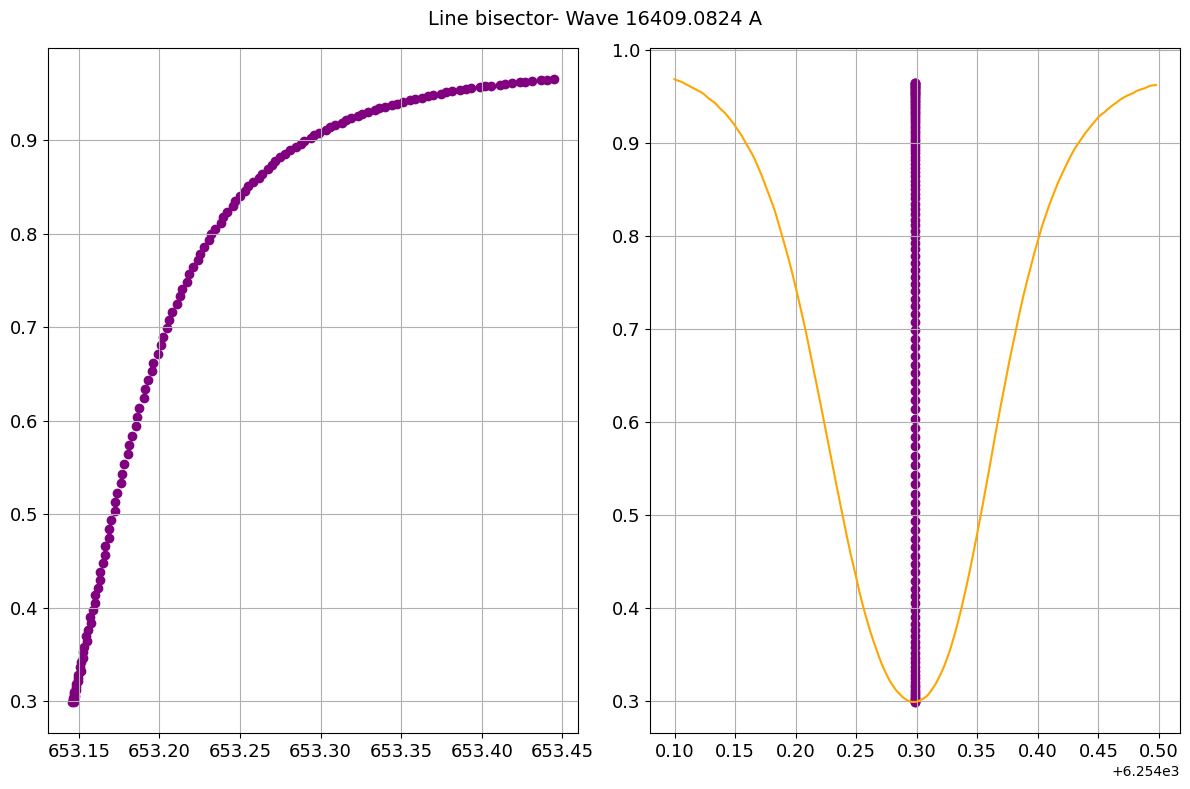

In [79]:
j = 374
fig6, axis1 = plt.subplots(1,2, figsize = (12, 8))
ax1 = axis1[0]
ax2 = axis1[1]

fig6.suptitle(r'Line bisector- Wave 16409.0824 A',fontsize=14)

ax1.scatter(bisectors[j]['Velocity'],bisectors[j]['Flux'],color= 'purple')

ax2.plot(local_points_bis[j]['Wave A'],local_points_bis[j]['nFlux'],color= 'orange')
ax2.scatter(bisectors[j]['Distance'],bisectors[j]['Flux'],color= 'purple')


ax1.grid()
ax1.tick_params(axis='both',labelsize=13)
# ax1.set_xlim(97,99)

ax2.grid()
ax2.tick_params(axis='both',labelsize=13)

fig6.tight_layout()

# fig6.savefig('Relation_coef.pdf')

In [96]:
l = 6254.2850 #the closer to 6253

dat = closer_lines[closer_lines['Fe line']  == l].index[0]
data = bisectors[dat]

standa = curve_standard['Vel fit']
planck_flux = data['Flux']-standa
planck_flux = planck_flux.loc[0:len(curve_standard['Vel fit'])-1]


122

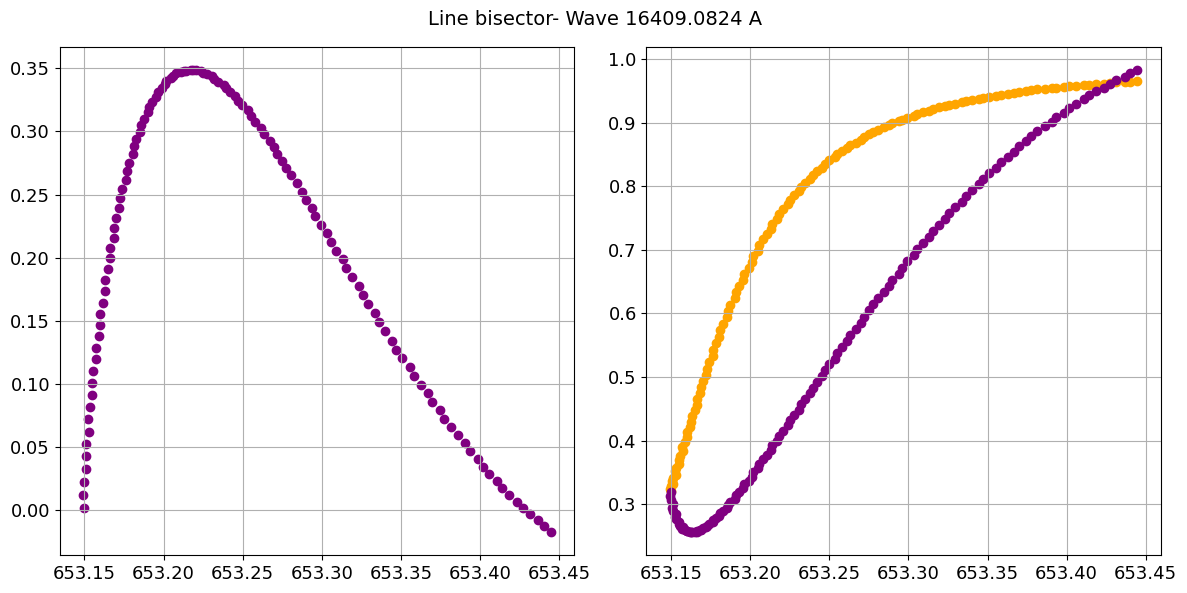

In [100]:


data['P flux'] = planck_flux
fig6, axis1 = plt.subplots(1,2, figsize = (12,6))
ax1 = axis1[0]
ax2 = axis1[1]

fig6.suptitle(r'Line bisector- Wave 16409.0824 A',fontsize=14)

ax1.scatter(data['Velocity'].loc[0:len(curve_standard['Vel fit'])-1],planck_flux,color= 'purple')

ax2.scatter(data['Velocity'].loc[0:len(curve_standard['Vel fit'])-1],data['Flux'].loc[0:len(curve_standard['Vel fit'])-1],color= 'orange')
ax2.scatter(data['Velocity'].loc[0:len(curve_standard['Vel fit'])-1],curve_standard['Vel fit'],color= 'purple')


ax1.grid()
ax1.tick_params(axis='both',labelsize=13)


ax2.grid()
ax2.tick_params(axis='both',labelsize=13)

fig6.tight_layout()

# fig6.savefig('Relation_coef.pdf')

In [66]:
maximum = data[data['P flux'] == max(data['P flux'])]
mean = data[data['Velocity'] <= np.mean(data['Velocity'])].head(1)


Take this and the planck distribution

$$I(\lambda ,T)=\frac{2\pi hc^{2}}{\lambda ^{5}}\frac{1}{e^{\frac{hc}{\lambda k_{B}T}}-1}$$

But the relation between Flux and intensity is 
$$  F =\int_0^{2\pi}\int_0^{\pi} I(\theta,\phi) \sin(\theta)d\theta d\phi$$
Assume that the sun is radiating isotropic $F=4\pi I$. And for $\lambda$ to take the velocity (without the relativistic fit)

$$v_r= \big( \frac{\lambda_{obs}}{\lambda_{nat}} - 1 \big) c \quad \quad \lambda = (v_r/c + \lambda_{nat})$$

The $\lambda_{obs}$ is my variable.

$$I(\lambda ,T)= \frac{F}{4\pi}= \frac{2\pi hc^{2}}{(v_r/c + \lambda_{nat}) ^{5}}\frac{1}{e^{\frac{hc}{(v_r/c + \lambda_{nat}) k_{B}T}}-1} = $$

I just want to take the Temperature:
$$\frac{4\pi}{F} \frac{2\pi hc^{2}}{(v_r/c + \lambda_{nat}) ^{5}} + 1 = e^{\frac{hc}{(v_r/c + \lambda_{nat}) k_{B}T}}\quad \quad \ln\bigg( \frac{4\pi}{F} \frac{2\pi hc^{2}}{(v_r/c + \lambda_{nat}) ^{5}} + 1 \bigg) = \frac{hc}{(v_r/c + \lambda_{nat}) k_{B}T}$$

$$ \frac{hc}{(v_r/c + \lambda_{nat}) k_{B}\ln\bigg( \frac{4\pi}{F} \frac{2\pi hc^{2}}{(v_r/c + \lambda_{nat}) ^{5}} + 1 \bigg)} = T $$

In [74]:
# \frac{hc}{(v_r/c + \lambda_{nat}) k_{B}\ln\bigg( \frac{4\pi}{F} \frac{2\pi hc^{2}}{(v_r/c + \lambda_{nat}) ^{5}} + 1 \bigg)} = T 

def Temperature(v,lamda, flux):
    new_l = lamda
    log = np.log((4*np.pi / flux)*((2*np.pi*const.h*const.c**2) /new_l) +1  )
    return (const.h*const.c) , (new_l*log*const.Boltzmann),log

Temperature(maximum['Velocity'].iloc[0], 6254.2850 , maximum['P flux'].iloc[0] )

(1.9864458571489286e-25, 0.0, 0.0)

In [70]:
maximum['P flux'].iloc[0]

0.348648899844209